<a href="https://colab.research.google.com/github/zinengtang/TVLT/blob/main/Demo_Video_Audio_MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TVLT Masked Autoencoding

This notebook demonstrates the masked autoencoding in TVLT on video and audio inputs.

## Check GPU status

In [1]:
!nvidia-smi

Thu Sep 29 01:26:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download code and install dependencies

In [2]:
!git clone https://github.com/zinengtang/TVLT

Cloning into 'TVLT'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 81 (delta 3), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (81/81), done.


In [3]:
cd /content/TVLT

/content/TVLT


In [4]:
pwd

'/content/TVLT'

In [5]:
!pip install -q torch==1.10.0 torchvision==0.11.1 torchaudio==0.10.0 torchtext
!pip install -q -r requirements.txt
!pip install -q imageio==2.4.1

     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x66652000 @  0x7f81b20bf615 0x58e046 0x4f2e5e 0x4d19df 0x51b31c 0x5b41c5 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51837f 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4ba70a 0x538136 0x590055 0x51b180 0x5b41c5 0x58f49e 0x51837f 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x517947 0x5b41c5 0x58f49e
     |████████████████████████████████| 881.9 MB 20 kB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 2.9 MB 60.9 MB/s 
     |████████████████████████████████| 1.9 MB 44.4 MB/s 
     |████████████████████████████████| 10.4 MB 50.7 MB/s 
     |████████████████████████████████| 8.0 MB 49.4 MB/s 
     |████████████████████████████████| 8.0 MB 52.1 MB/s 
     |████████████████████████████████| 8.0 MB 50.5 MB/s 
     |████████████████████████████████| 585 kB 31.2 MB/s 
     |████████████████████████████████| 4.4 MB 59.1 MB/s 
     |███

### Load model for audio and video reconstruction

In [6]:
%load_ext autoreload
%autoreload 2

from demos import MAE_model
model = MAE_model()

Downloading:   0%|          | 0.00/457M [00:00<?, ?B/s]

In [7]:
device = 'cuda'
# device  = 'cpu'

model.to(device)

model.eval();

### Load sample data

In [8]:
from model.data.datasets.rawvideo_utils import load_audio, load_video, load_video_audio

video_path = 'demo_samples/Howto100m/mg7Q4o9bNN0.mp4'  # replace your own video (with audio) here
timestamp = [42.0,48.0]  # set the timestamp
num_frames = 1   # set number of frames to sample
video, audio = load_video_audio(video_path, num_frames=1, sr=44100, timestamp=timestamp)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3022848/45929032 bytes (6.6%)6021120/45929032 bytes (13.1%)9084928/45929032 bytes (19.8%)11730944/45929032 bytes (25.5%)14000128/45929032 bytes (30.5%)16523264/45929032 bytes (36.0%)18931712/45929032 bytes (41.2%)21078016/45929032 bytes (45.9%)23928832/45929032 bytes (52.1%)26451968/45929032 bytes (57.6%)29024256/45929032 bytes (63.2%)31809536/45929032 bytes (69.3%)

  "Argument interpolation should be of type InterpolationMode instead of int. "

  nbytes=2, chunksize=buffersize))



Please take notes about the size of the input video and audio.
* Dimension of input video tensor: (batch_size, number_of_frames, rgb_channel, width, height)  
* Dimension of input audio tensor: (batch_size, number_of_audio_channels, time, spectrogram)

In [9]:
print("Input video tensor size:", video.size())
print("Input audio tensor size:", audio.size())


Input video tensor size: torch.Size([1, 1, 3, 224, 224])
Input audio tensor size: torch.Size([1, 1, 528, 128])


In [10]:
audio_feature_len = 528  # save the length of audio feature (will be used in visualization)

### Inference

In [11]:
video = video.to(device)
audio = audio.to(device)

In [12]:
import torch
with torch.no_grad():
  _, decoder_audio_outputs, decoder_video_outputs, _, mask_a, mask_v = model(video=video, audio=audio, mask_visual=True, use_mae=True)
  pred_v = model.mae_score_video(decoder_video_outputs).detach().cpu().numpy() 
  pred_a = model.mae_score_audio(decoder_audio_outputs).detach().cpu().numpy() 

TVLT will split the input video frame and audio spectrogram into $16\times 16$ patches.  
This will give us $\frac{224}{16} \times \frac{224}{16} = 196$ video patches and $\frac{528}{16} \times \frac{128}{16} = 264$ audio patches.  
Those patch inputs will be feeded to a transformer encoder (768-dimension) and then to a transformer decoder (512-dimension).  
See the size of the output tensors for video and audio.

In [13]:
print("Decoded Video outputs Size:", decoder_video_outputs.size())
print("Decoded Audio outputs Size:", decoder_audio_outputs.size())

Decoded Video outputs Size: torch.Size([1, 196, 512])
Decoded Audio outputs Size: torch.Size([1, 264, 512])


Finally, we would like to recover the original video frame and audio spectrogram.  
For each video frame patch, we will need to recover a total number of $16\times 16 \times 3 = 768$ scalar values.  
For each audio spectrogram patch, will need to recover a total number of $16 \times 16 \times 1 = 256$ scalar values.  

In [14]:
print("reconstructed video tensor Size:", pred_v.shape)
print("reconstructed audio tensor Size:", pred_a.shape)

reconstructed video tensor Size: (1, 196, 768)
reconstructed audio tensor Size: (1, 264, 256)


### Visualize video reconstruction

Original Video Frame


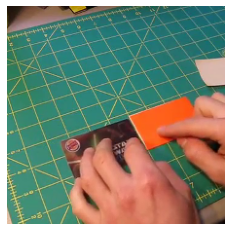

Reconstruction of the Masked Patches of the Frame


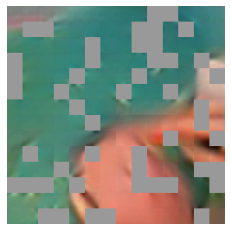

In [15]:
from demos import visualize_video
print('Original Video Frame')
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow((video.squeeze()/2+0.5).permute(1,2,0).cpu().numpy())
plt.show()


print('Reconstruction of the Masked Patches of the Frame')
masked_pred_v = pred_v.copy()
masked_pred_v[~mask_v.cpu().bool()] = 0.2
visualize_video(masked_pred_v)

We compare the predicted masked patches with the groudtruth patches and use MSE loss as one of the objectives (we also use contrastive loss) to train TVLT.

You can also use the model to do full reconstruction on the input frame given the masked input.  
See the visual below.

We can also do full reconstruction for all the patches (both masked and unmasked).


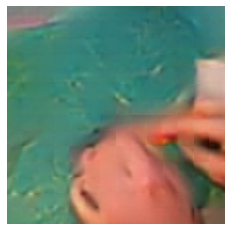

In [16]:
print('We can also do full reconstruction for all the patches (both masked and unmasked).')
visualize_video(pred_v)

### Visualize audio reconstruction

Original Audio Spectrogram


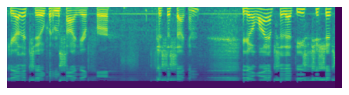

Reconstruction of the Masked Spectrogram


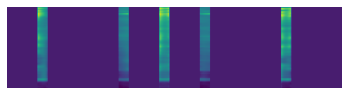

In [17]:
from demos import visualize_audio
print('Original Audio Spectrogram')
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow((audio.squeeze()/2+0.5).permute(1,0).cpu().numpy())
plt.show()


print('Reconstruction of the Masked Spectrogram')
masked_pred_a = pred_a.copy()
masked_pred_a[~mask_a.cpu().bool()] = -0.7
visualize_audio(masked_pred_a, audio_len=audio_feature_len)

Similar to video reconstruction, we compare the predicted masked patches with the groudtruth patches and use MSE loss as one of the objectives (we also use contrastive loss) to train TVLT.  

Note that we do "whole word masking" for the audio spectrogram where the whole frequency-axis is masked for detected speeches. Please refer to the [codebase](https://github.com/zinengtang/TVLT/blob/9ae702ce7984b62a79173b1e2b174f0145bd64ec/model/modules/tvlt.py#L356) for details about audio masking.

We can also do full reconstruction for all the patches (both masked and unmasked).


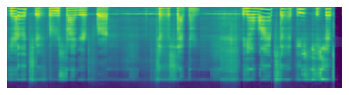

In [18]:
print('We can also do full reconstruction for all the patches (both masked and unmasked).')
visualize_audio(pred_a, audio_len=audio_feature_len)